# 1 Import libraries and data

In [177]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve
from imblearn.over_sampling import SMOTE

In [178]:
df = pd.read_csv('Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2 Data Preprocessing

In [179]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- Meta Columns (RowNumber, CustomerId, Surname) 
- Categorical Columns (Geography, Gender) 
- Numerical Columns (CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary)
- Binary Columns (HasCrCard, IsActiveMember)
- Target Variable (Exited)


In [180]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [181]:
df.duplicated().sum()

0

No misiing values or duplicates in the dataset

In [182]:
df.nunique(axis=0)

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

In [183]:
columns_to_drop = ['RowNumber',	'CustomerId','Surname'] 
df = df.drop(columns=columns_to_drop)

Unnecesary columns have been removed

In [184]:
df.rename(columns={'Exited': 'Churn'}, inplace=True)

Target column has been renamed

In [185]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### Encoding categorical variables


In [186]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender']) 
df=pd.get_dummies(df, columns=['Geography'], drop_first=False)

In [187]:
df.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,True,False,False
1,608,0,41,1,83807.86,1,0,1,112542.58,0,False,False,True
2,502,0,42,8,159660.80,3,1,0,113931.57,1,True,False,False
3,699,0,39,1,0.00,2,0,0,93826.63,0,True,False,False
4,850,0,43,2,125510.82,1,1,1,79084.10,0,False,False,True


### Check for outliers

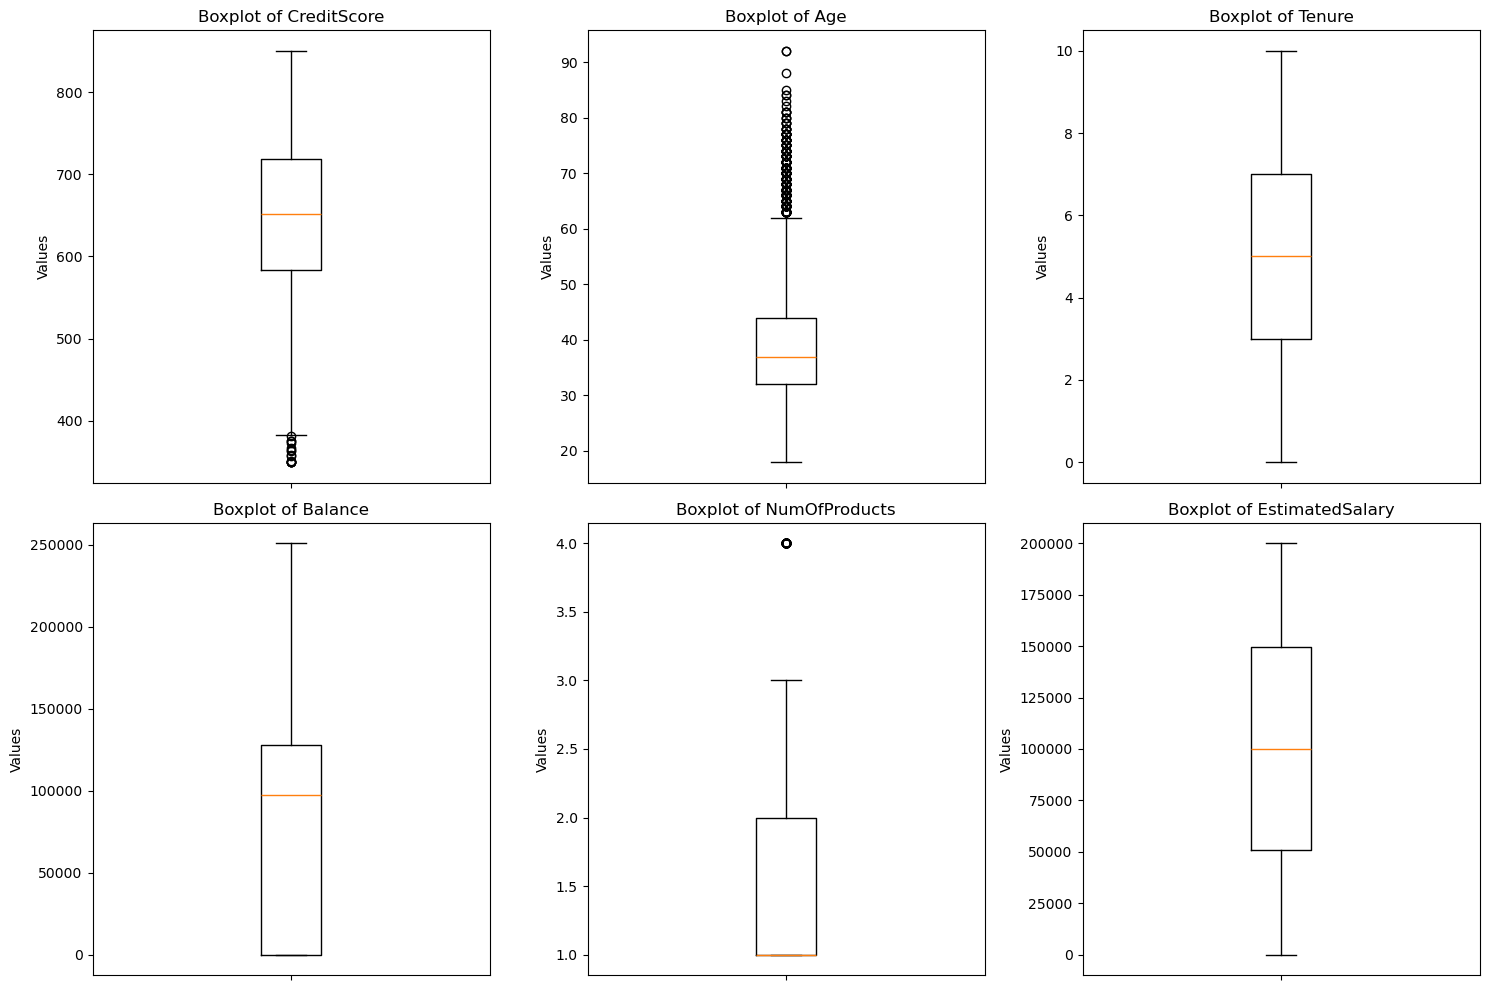

In [188]:
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'] 
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

for i, col in enumerate(numeric_cols):
    row = i // 3
    col_index = i % 3
    axes[row, col_index].boxplot(df[col])
    axes[row, col_index].set_title(f'Boxplot of {col}')
    axes[row, col_index].set_ylabel('Values')
    axes[row, col_index].set_xticklabels([])

plt.tight_layout()
plt.show()

In [189]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return series[(series < lower_bound) | (series > upper_bound)].count()

for col in numeric_cols:
    outlier_count = count_outliers(df[col])
    print(f"{col} has {outlier_count} outliers")

CreditScore has 15 outliers
Age has 359 outliers
Tenure has 0 outliers
Balance has 0 outliers
NumOfProducts has 60 outliers
EstimatedSalary has 0 outliers


Outliers will be treated before modelling

### Distribution of numerical variables

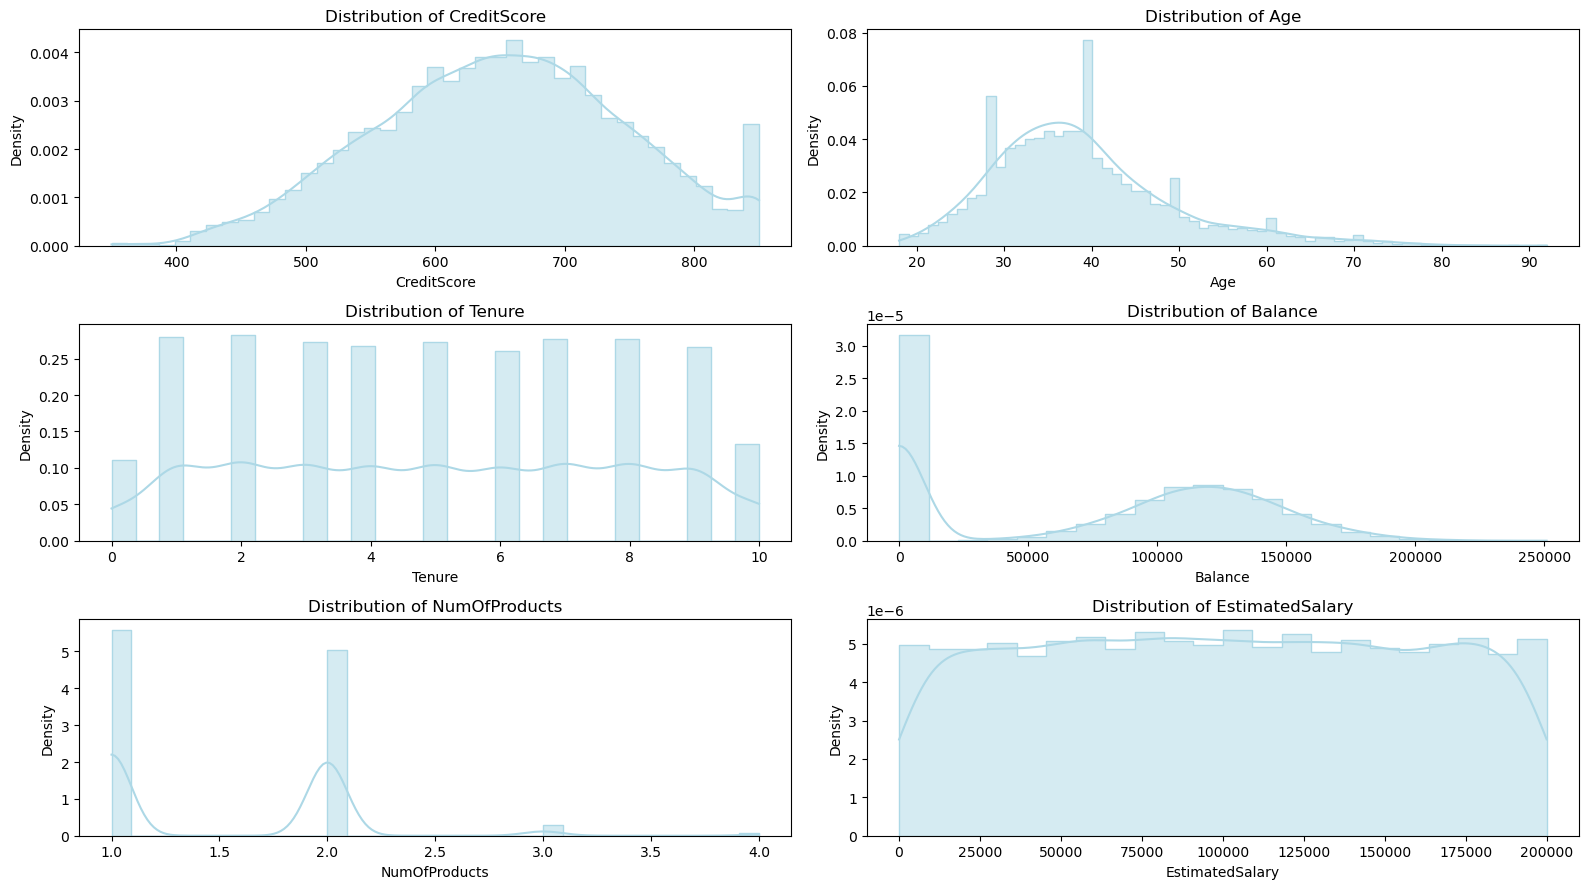

In [190]:
plt.figure(figsize=(16, 9))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(3, 2, i)
    sns.histplot(data=df, x=col, element='step', stat='density', common_norm=False, kde=True, color='lightblue')
    plt.title(f'Distribution of {col}', fontsize=12)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('Density', fontsize=10)
plt.tight_layout()
plt.show()

Key observations:
- CreditScore - distribution  roughly normal, slightly left-skewed. Most customers have a credit score between 550 and 800.  

- Age - right-skewed, has a lot of outliers.

- Tenure - has uniform distribution. The number of years customers have been with the bank is evenly distributed from 1 to 9 years.

- Balance - bimodal distribution with peak at 0 and then a bell curve shape from 50k to 200k. Many customers have a zero balance, likely inactive or new customers. 

- NumOfProducts - discrete distribution. Majority of customers use only 1 or 2 products.

- EstimatedSalary - fairly uniform distribution. The income distribution is evenly spread, suggesting this might be a synthetic dataset or sampled to avoid salary bias.

### Evaluate summary statistics

In [191]:
df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,0.545700,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,0.497932,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,1.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# 3 Exploratory Data Analysis

### Proportion of customers in binary columns

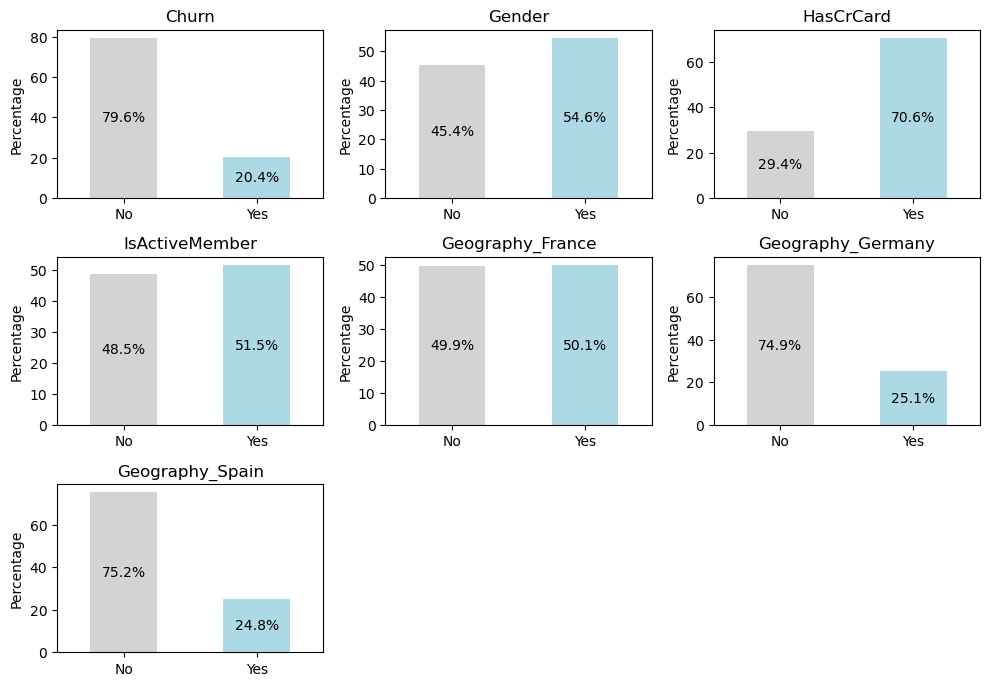

In [192]:
bin_columns = ['Churn', 'Gender', 'HasCrCard', 'IsActiveMember', 'Geography_France','Geography_Germany', 'Geography_Spain']

cat_var_proportions = df[bin_columns].apply(
    lambda x: (x.value_counts(normalize=True) * 100).round(1)
).T
sorted_by_third_col = cat_var_proportions.sort_values(
    by=cat_var_proportions.columns[1], ascending=True
)

plt.rcParams['figure.figsize'] = (12, 9)
fig, axes = plt.subplots(nrows=(len(bin_columns) + 1) // 2, ncols=3, figsize=(10, 9))
axes = axes.flatten()

for i, col in enumerate(bin_columns):
    sorted_by_third_col.loc[col].plot(kind='bar', ax=axes[i], color=['#d3d3d3', '#add8e6'], title=col)
    
    axes[i].set_xticklabels(['No', 'Yes'])
    
    for p in axes[i].patches:
        width, height = p.get_width(), p.get_height()
        x, y = p.get_xy()
        if height > 0:
            axes[i].text(x + width / 2, y + height / 2, f'{height:.1f}%', ha='center', va='center', fontsize=10, color='black')
    
    axes[i].set_ylabel('Percentage')
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=0)
    axes[i].grid(False, axis='x')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Key observations:

- The target variable Churn is imbalanced, with only 20.4% of customers having churned.

- 50% of customers reside in France, while Germany and Spain each account for approximately 25%.

- There is a 9% higher proportion of males compared to females in the customer base.

- Over 70% of customers possess a credit card.

- The number of active members exceeds inactive ones by 3%.



### Boxplot Analysis of Churn

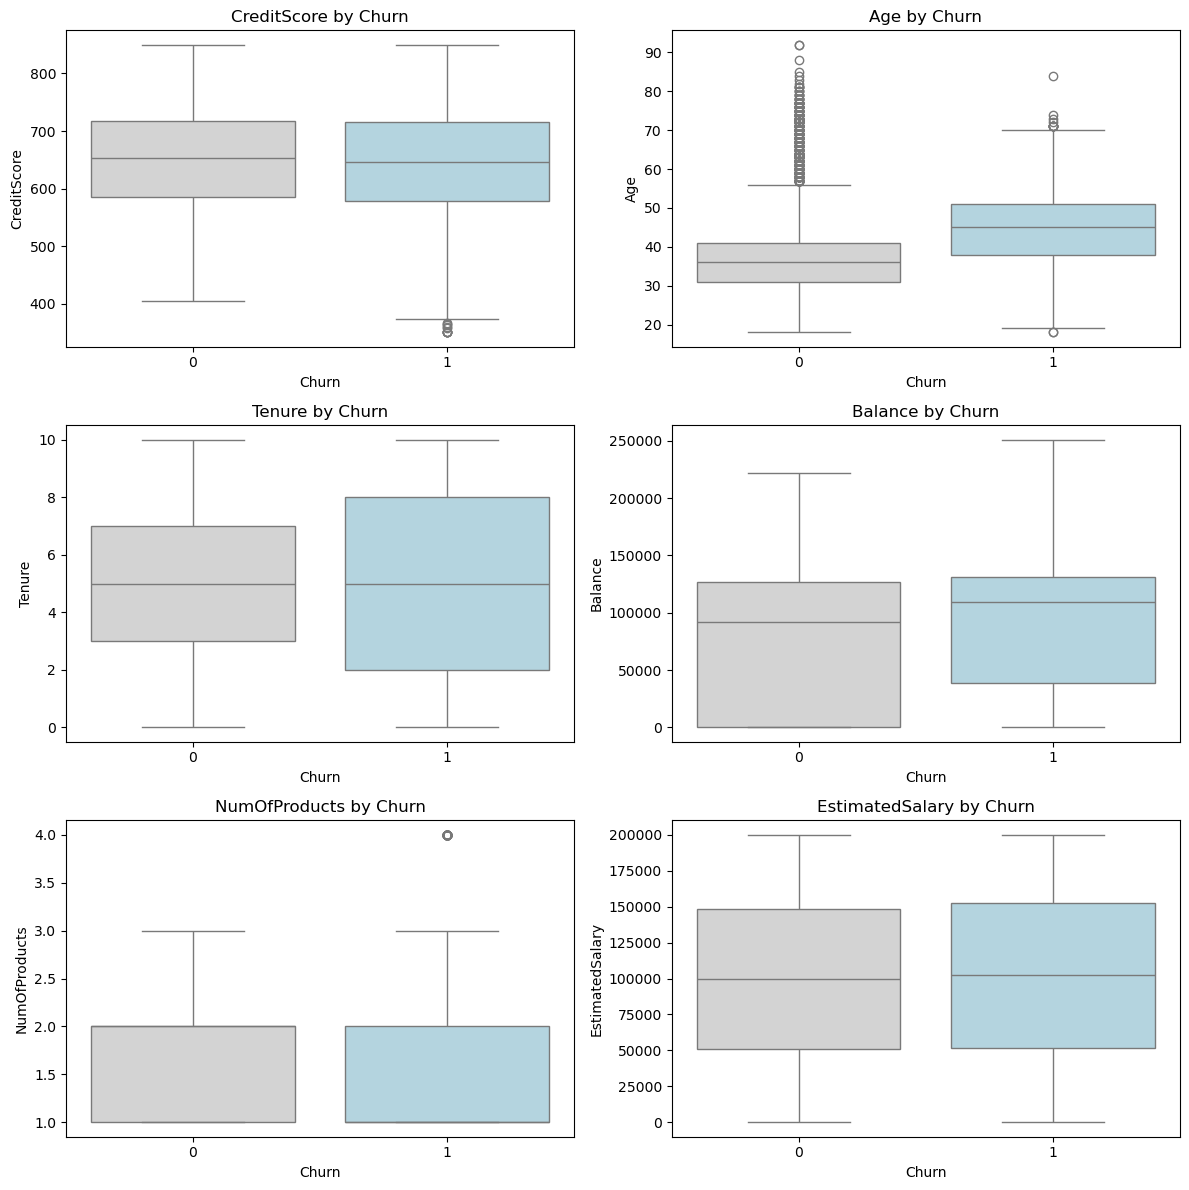

In [193]:
custom_palette = ['#d3d3d3', '#add8e6']
n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    sns.boxplot(
        data=df, x='Churn', y=col, hue='Churn',
        palette=custom_palette, dodge=False, ax=axes[i]
    )
    axes[i].set_title(f'{col} by Churn')
    axes[i].set_xlabel('Churn')
    axes[i].legend_.remove()   

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Key observations: 
- CreditScore: The medians are similar across churned and non-churned customers, suggesting no major difference in credit score distribution.

- Age: Churned customers have a higher median age, indicating that older customers are more likely to churn.

- Tenure: Median tenure is  quite similar for both groups of customers.

- Balance: Churned customers tend to have a slightly higher median balance, suggesting that customers with more money in their accounts may be more likely to churn.

- NumOfProducts: Most customers have 1 or 2 products, and there's no notable difference in medians between churn groups.

- EstimatedSalary: Median salaries are very close between churned and non-churned customers, implying limited influence on churn.

### Proportion of churned vs. retained customers

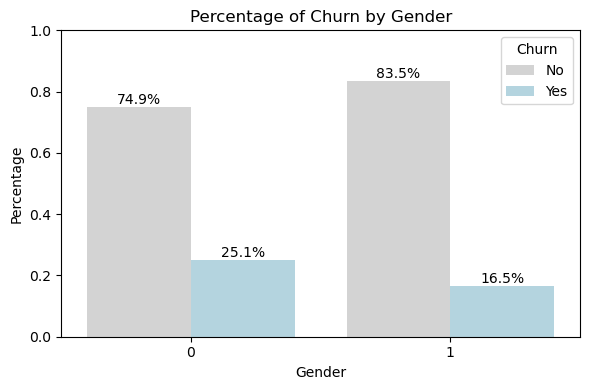

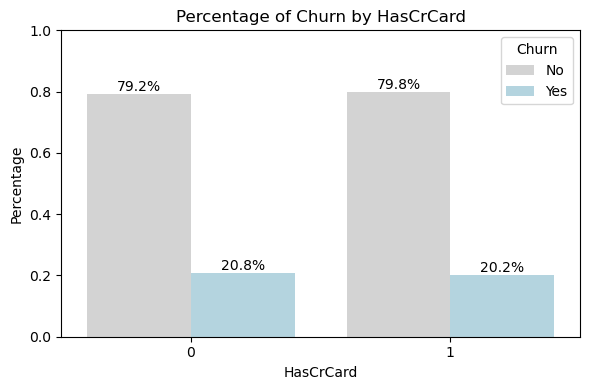

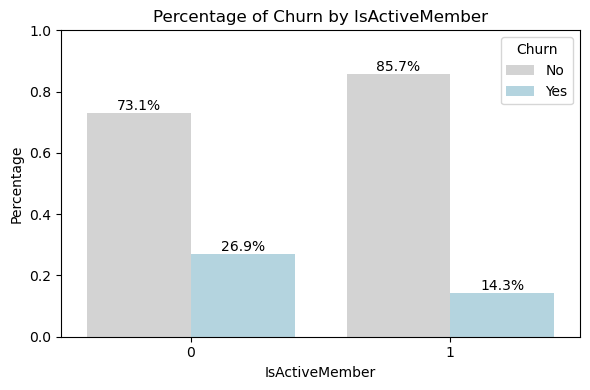

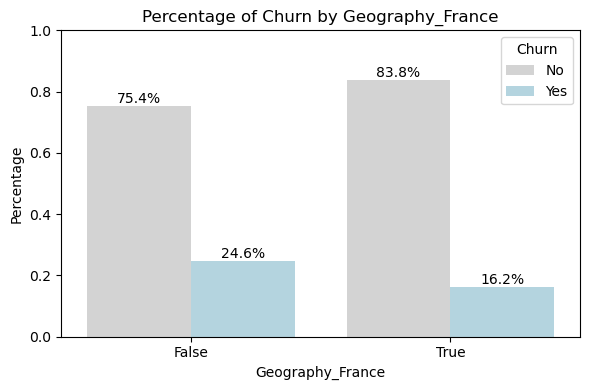

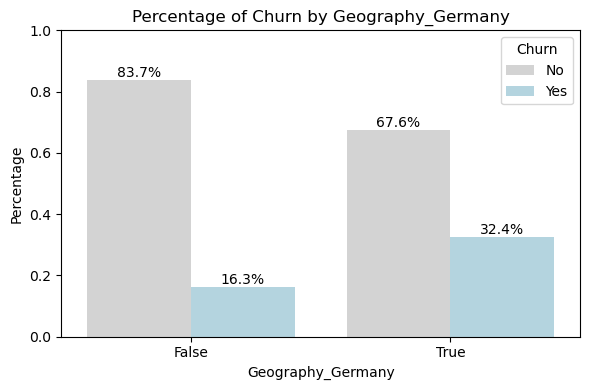

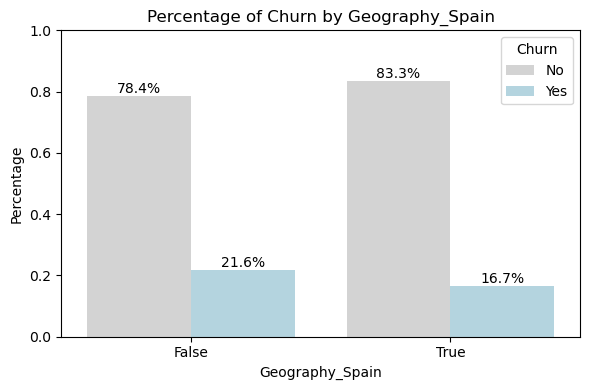

In [194]:
cat_cols = ['Gender', 'HasCrCard', 'IsActiveMember', 'Geography_France', 'Geography_Germany', 'Geography_Spain']

for col in cat_cols:
    prop_df = (
        df.groupby(col)['Churn']
        .value_counts(normalize=True)
        .rename('Proportion')
        .reset_index()
    )

    plt.figure(figsize=(6, 4))
    ax = sns.barplot(data=prop_df, x=col, y='Proportion', hue='Churn', palette=custom_palette)

    for p in ax.patches:
        height = p.get_height()
        if height > 0.01:
            ax.annotate(f'{height:.1%}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10)

    plt.title(f'Percentage of Churn by {col}')
    plt.ylabel('Percentage')
    plt.xlabel(col)
    plt.ylim(0, 1)

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=['No', 'Yes'], title='Churn')

    plt.tight_layout()
    plt.show()

Key obserevations:
- Churn is higher among females (25.1%) compared to males (16.5%).

- Credit card ownership does not significantly affect churn, with similar rates for customers with (20%) and without (21%) a credit card.

- Active members are less likely to churn (14.3%) compared to inactive members, who show a significantly higher churn rate of 26.9%.

- Customers from Germany have the highest churn rate (32%), which is substantially higher than those from France and Spain, both around 16%.

### Correlation analysis

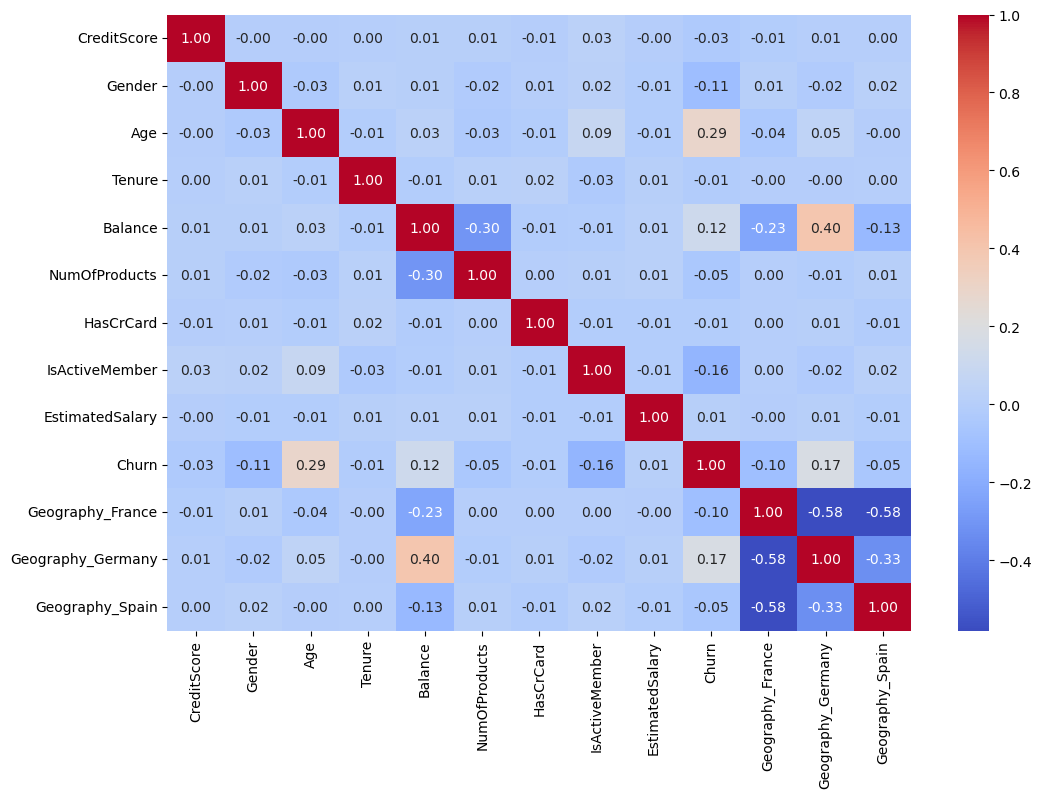

In [195]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

There is no evidence of multicollinearity among the independent variables.

The target variable Churn shows stronger correlations with independent variables such as Age and Geography_Germany (positive), and  IsActiveMember (negative).

### Traeating outliers

In [196]:
def cap_outliers_iqr(df, cols):
    df = df.copy()
    for col in cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df[col] = df[col].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
        df[col] = df[col].round().astype(int)
    return df

In [197]:
df = cap_outliers_iqr(df, ['Age', 'CreditScore'])

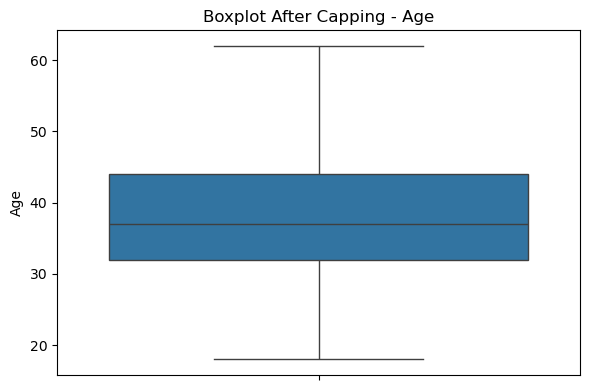

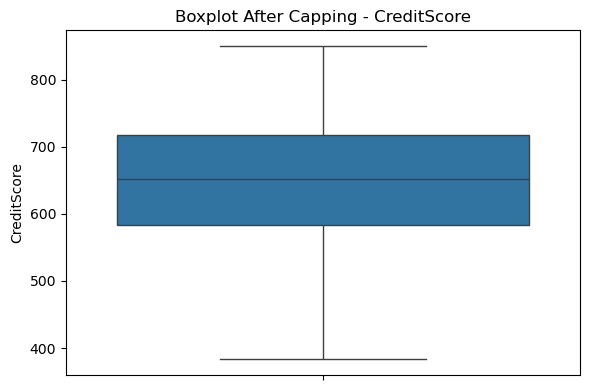

In [198]:
for col in ['Age', 'CreditScore']:
    plt.figure(figsize=(6, 4))
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot After Capping - {col}')
    plt.tight_layout()
    plt.show()

There are no outliers after treating.

In [199]:
df.shape

(10000, 13)

In [200]:
df.describe()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.561300,0.545700,38.660800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.558702,0.497932,9.746704,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,383.000000,0.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,0.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,1.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,1.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,1.000000,62.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


# 4 Implementation of ML models

### Feauture selection

In [201]:
list(df.columns)

['CreditScore',
 'Gender',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Churn',
 'Geography_France',
 'Geography_Germany',
 'Geography_Spain']

In [202]:
features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
            'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
            'Geography_France', 'Geography_Germany', 'Geography_Spain']

### Spliting the data

In [203]:
X = df[features]
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

### Feature Scaling & SMOTE

In [ ]:
scale_cols = ['CreditScore','Age','Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Scale  for SMOTE
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[scale_cols] = scaler.fit_transform(X_train[scale_cols])

# Apply SMOTE on scaled data
sm = SMOTE(random_state=1)
X_train_resampled_scaled, y_train_resampled = sm.fit_resample(X_train_scaled, y_train)

# Scale back to original values before training 
X_train_resampled = X_train_resampled_scaled.copy()
X_train_resampled[scale_cols] = scaler.inverse_transform(X_train_resampled_scaled[scale_cols])

# Prepare scaled version of test set for models that need scaling
X_test_scaled = X_test.copy()
X_test_scaled[scale_cols] = scaler.transform(X_test[scale_cols])

- Due to class imbalance in the target variable, SMOTE was applied to the scaled training data to synthetically balance the minority class. Scaling was necessary prior to SMOTE to ensure all features contribute equally to the distance-based algorithm. 

- After resampling, inverse transformation was applied to restore the original feature distributions, allowing compatibility with tree-based models which do not require feature scaling. 

- Separately scaled test set was prepared for evaluation with models sensitive to feature magnitude, such as logistic regression, SVM, KNN, and Gaussian Naive Bayes—ensuring consistent input distributions.

### Decision Tree

In [205]:
dt = DecisionTreeClassifier(random_state=1, class_weight='balanced')
dt.fit(X_train_resampled, y_train_resampled)

y_pred_dt = dt.predict(X_test)

print("\n🌳 Decision Tree + SMOTE")
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_dt))


🌳 Decision Tree + SMOTE
[[1306  287]
 [ 183  224]]
              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1593
           1       0.44      0.55      0.49       407

    accuracy                           0.77      2000
   macro avg       0.66      0.69      0.67      2000
weighted avg       0.79      0.77      0.77      2000

✅ Accuracy: 0.765


🎯 ROC AUC Score: 0.6851026681535157


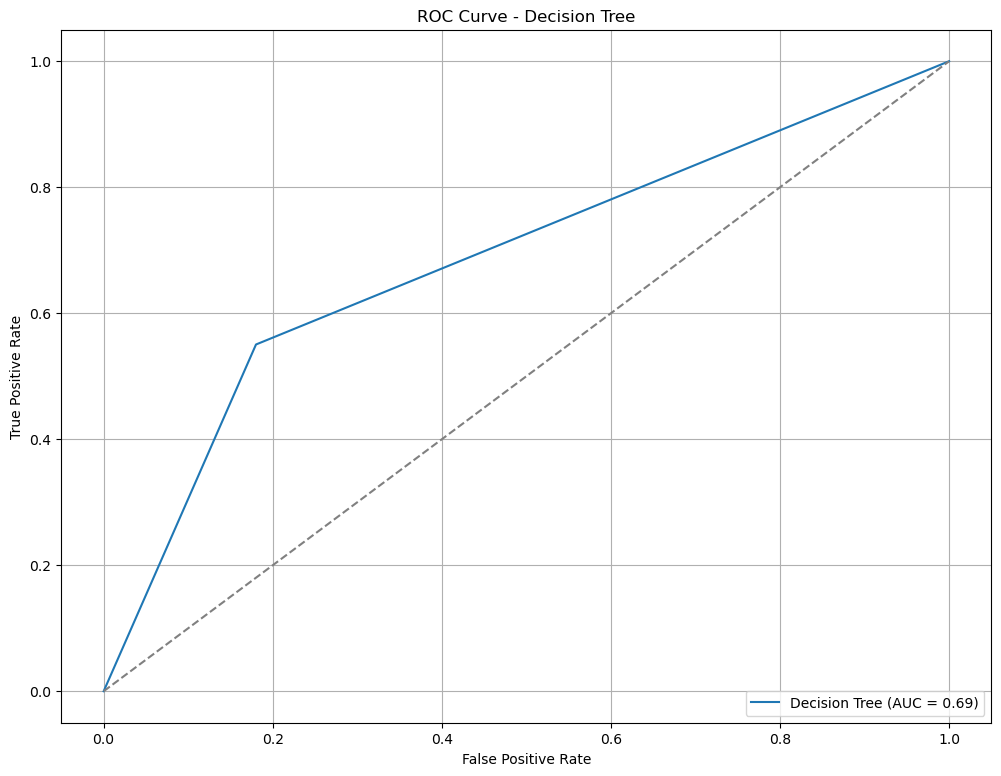

In [206]:
# Predict probabilities for ROC AUC
y_pred_proba_dt = dt.predict_proba(X_test)[:, 1]

# ROC AUC Score
roc_auc_dt = roc_auc_score(y_test, y_pred_proba_dt)
print("🎯 ROC AUC Score:", roc_auc_dt)

# Plot ROC Curve
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred_proba_dt)

plt.figure()
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Random Forest

In [207]:
# GridSearch on resampled & unscaled data
param_grid = {
    'max_samples': [0.3, 0.5, 0.7, 1.0],
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

rf = RandomForestClassifier(random_state=1, class_weight='balanced', bootstrap=True, n_jobs=-1)

grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)

print("🔍 Best Params from GridSearch:")
print(grid_search.best_params_)

# Use best estimator directly
best_rf = grid_search.best_estimator_

# Predict on test set (which remains unscaled)
y_pred_smote = best_rf.predict(X_test)

print("\n📊 Random Forest + SMOTE (GridSearch Optimized)")
print(confusion_matrix(y_test, y_pred_smote))
print(classification_report(y_test, y_pred_smote))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_smote))

🔍 Best Params from GridSearch:
{'max_depth': None, 'max_samples': 1.0, 'min_samples_split': 2, 'n_estimators': 200}

📊 Random Forest + SMOTE (GridSearch Optimized)
[[1430  163]
 [ 176  231]]
              precision    recall  f1-score   support

           0       0.89      0.90      0.89      1593
           1       0.59      0.57      0.58       407

    accuracy                           0.83      2000
   macro avg       0.74      0.73      0.74      2000
weighted avg       0.83      0.83      0.83      2000

✅ Accuracy: 0.8305


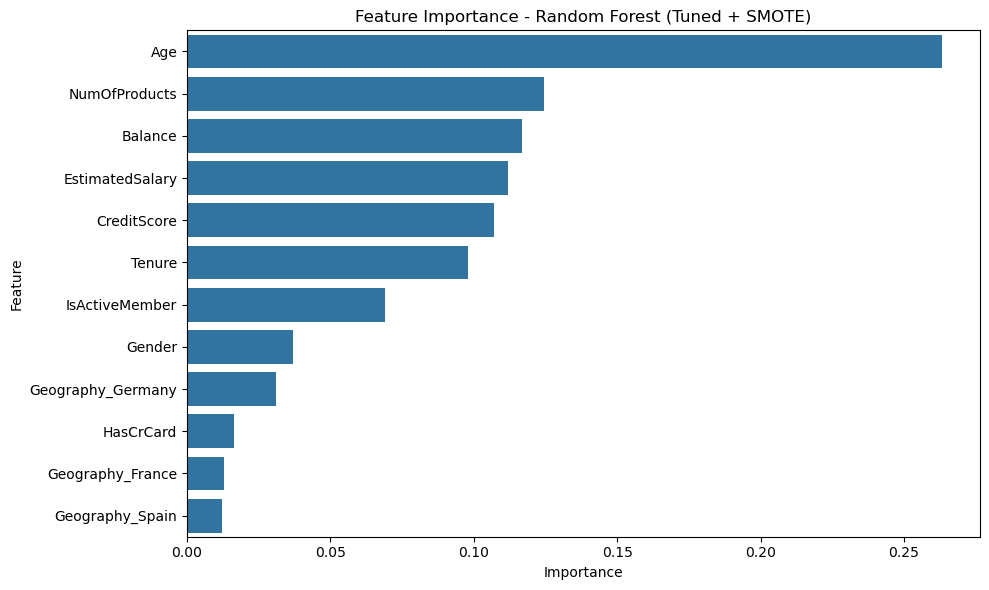

In [ ]:
# Get feature importances from best estimator
importances = best_rf.feature_importances_
features = X_train_resampled.columns

feat_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance)
plt.title('Feature Importance - Random Forest (Tuned + SMOTE)')
plt.tight_layout()
plt.show()

🎯 ROC AUC Score: 0.8419420961793844


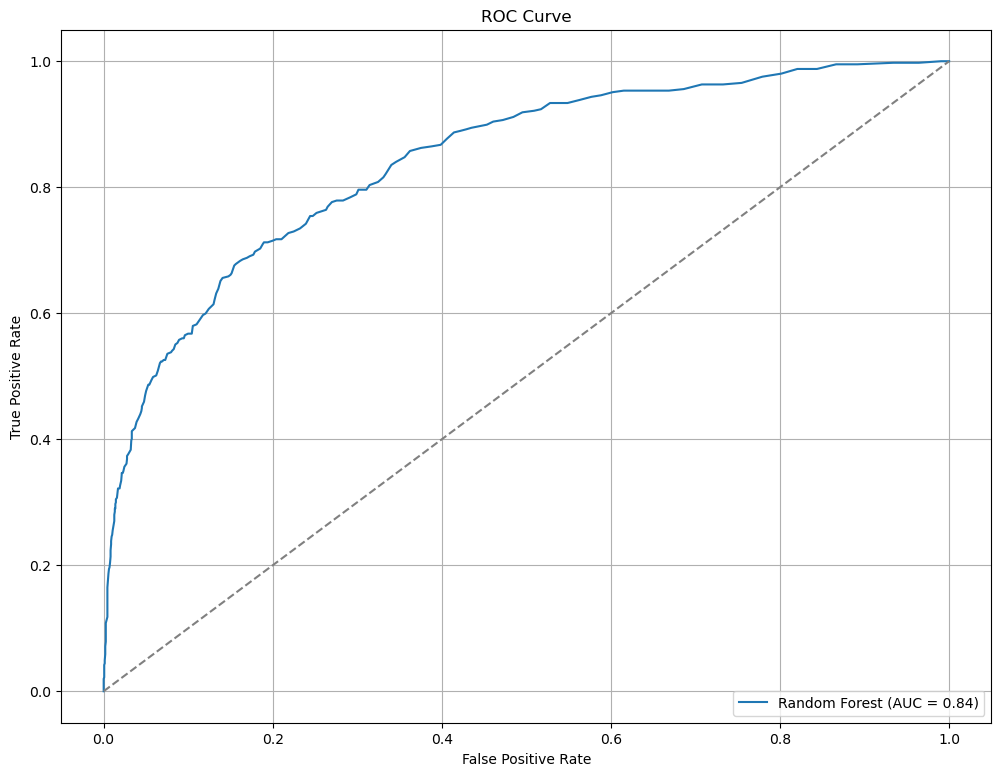

In [209]:
# Predict probabilities for ROC AUC
y_pred_proba_rf = best_rf.predict_proba(X_test)[:, 1]

# ROC AUC Score using probabilities
roc_auc_rf = roc_auc_score(y_test, y_pred_proba_rf)
print("🎯 ROC AUC Score:", roc_auc_rf)

# ROC Curve using probabilities
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba_rf)

# Plot ROC Curve
plt.figure()
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### XGBoost

In [210]:
xgb = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=1, 
    eval_metric='logloss',
    random_state=1
)

xgb.fit(X_train_resampled, y_train_resampled)

y_pred_xgb = xgb.predict(X_test)

print("\n🚀 XGBoost + SMOTE")
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_xgb))


🚀 XGBoost + SMOTE
[[1471  122]
 [ 180  227]]
              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1593
           1       0.65      0.56      0.60       407

    accuracy                           0.85      2000
   macro avg       0.77      0.74      0.75      2000
weighted avg       0.84      0.85      0.84      2000

✅ Accuracy: 0.849


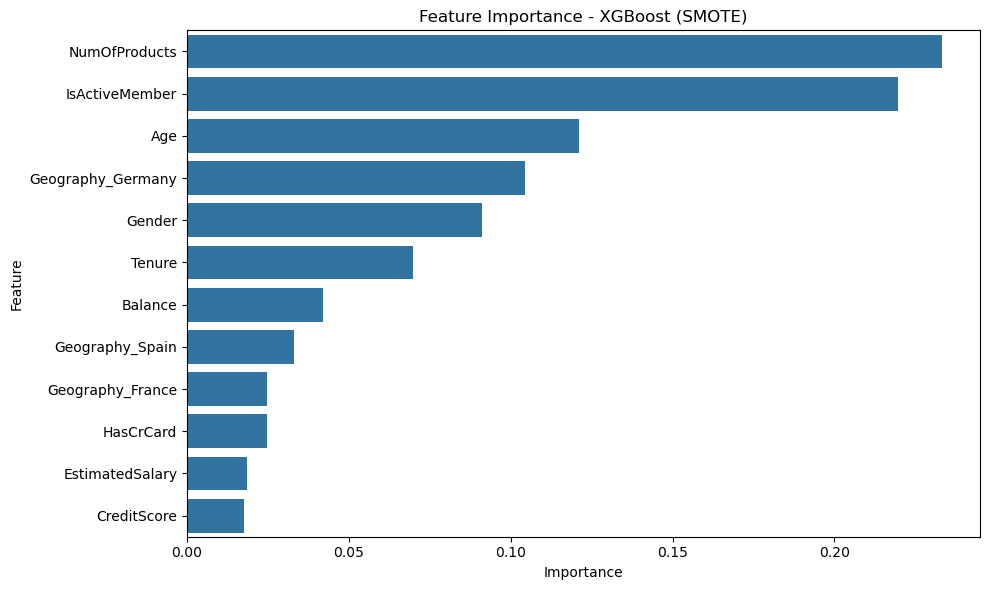

In [ ]:
# Get feature importances from the XGBoost model
importances = xgb.feature_importances_
features = X_train_resampled.columns

feat_importance_xgb = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_xgb)
plt.title('Feature Importance - XGBoost (SMOTE)')
plt.tight_layout()
plt.show()


🎯 ROC AUC Score: 0.8571452808740945


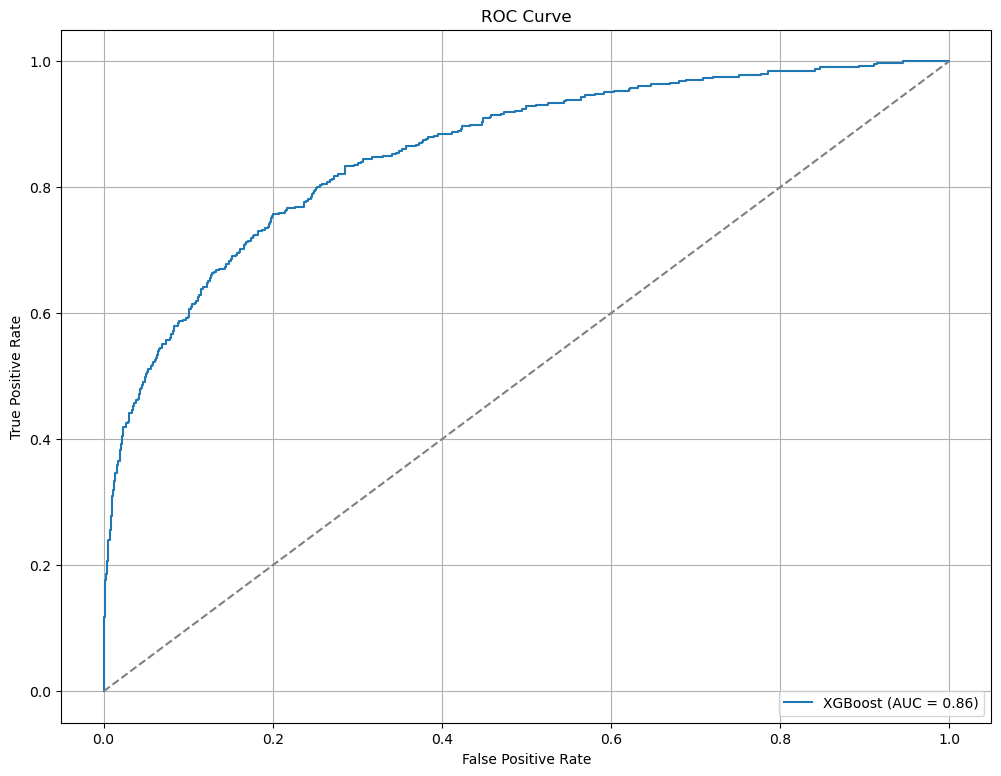

In [212]:
# Predict probabilities for ROC AUC
y_pred_proba_xgb1 = xgb.predict_proba(X_test)[:, 1]

# ROC AUC Score
roc_auc_xgb1 = roc_auc_score(y_test, y_pred_proba_xgb1)
print("🎯 ROC AUC Score:", roc_auc_xgb1)

# Plot ROC Curve
fpr_xgb1, tpr_xgb1, _ = roc_curve(y_test, y_pred_proba_xgb1)

plt.figure()
plt.plot(fpr_xgb1, tpr_xgb1, label=f'XGBoost (AUC = {roc_auc_xgb1:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

#### Apply GridSearch for XGBoost

In [213]:
xgb2 = XGBClassifier(
    eval_metric='logloss',
    random_state=1,
    n_jobs=-1
)

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'scale_pos_weight': [1]
}

grid_search_xgb = GridSearchCV(
    estimator=xgb2,
    param_grid=param_grid,
    scoring='f1',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb.fit(X_train_resampled, y_train_resampled)

print("🔍 Best XGBoost Params:")
print(grid_search_xgb.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
🔍 Best XGBoost Params:
{'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 200, 'scale_pos_weight': 1, 'subsample': 0.8}


In [214]:
best_xgb = grid_search_xgb.best_estimator_
y_pred_xgb_tuned = best_xgb.predict(X_test)

print("\n🚀 XGBoost (Tuned) + SMOTE")
print(confusion_matrix(y_test, y_pred_xgb_tuned))
print(classification_report(y_test, y_pred_xgb_tuned))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_xgb_tuned))


🚀 XGBoost (Tuned) + SMOTE
[[1453  140]
 [ 190  217]]
              precision    recall  f1-score   support

           0       0.88      0.91      0.90      1593
           1       0.61      0.53      0.57       407

    accuracy                           0.83      2000
   macro avg       0.75      0.72      0.73      2000
weighted avg       0.83      0.83      0.83      2000

✅ Accuracy: 0.835


🎯 ROC AUC Score: 0.8365931416778875


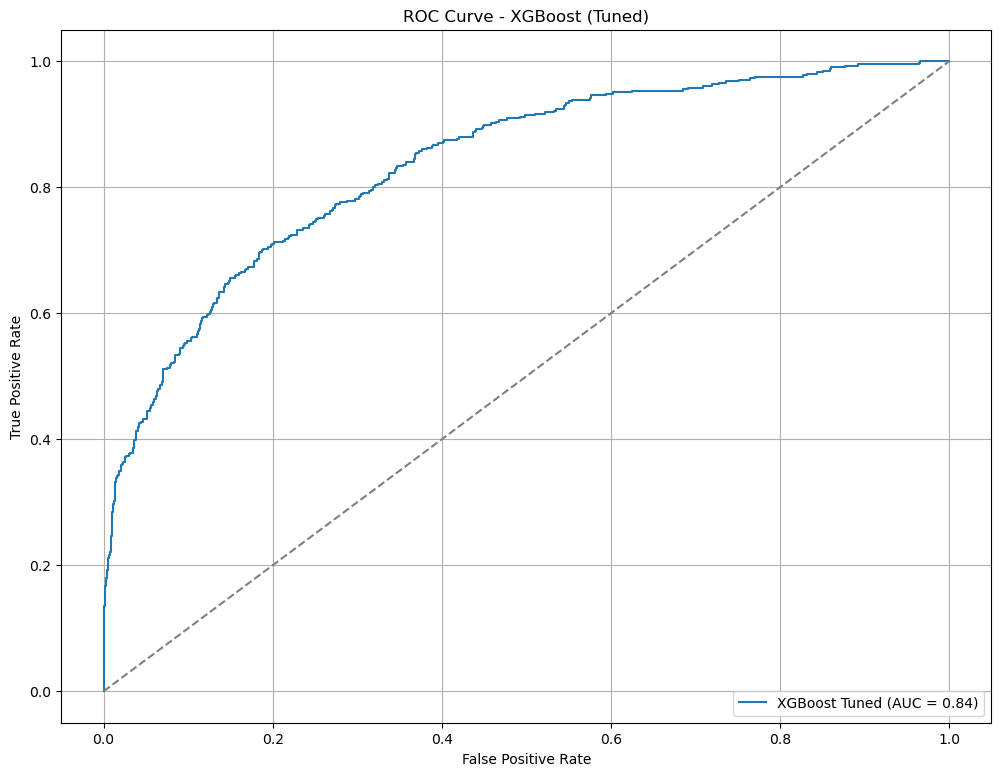

In [215]:
# Predict probabilities for ROC AUC
y_pred_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]

# ROC AUC Score
roc_auc_xgb = roc_auc_score(y_test, y_pred_proba_xgb)
print("🎯 ROC AUC Score:", roc_auc_xgb)

# Plot ROC Curve
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_proba_xgb)

plt.figure()
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost Tuned (AUC = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Tuned)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

### Gaussian Naive Bayes

In [216]:
nb = GaussianNB()
nb.fit(X_train_resampled_scaled, y_train_resampled)

y_pred_nb = nb.predict(X_test_scaled)

print("\n🧠 Naive Bayes + SMOTE (on Scaled Data)")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_nb))


🧠 Naive Bayes + SMOTE (on Scaled Data)
[[1230  363]
 [ 132  275]]
              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1593
           1       0.43      0.68      0.53       407

    accuracy                           0.75      2000
   macro avg       0.67      0.72      0.68      2000
weighted avg       0.81      0.75      0.77      2000

✅ Accuracy: 0.7525


### Support Vector Classification

In [217]:
svm = SVC(kernel='rbf', probability=True, random_state=1)

svm.fit(X_train_resampled_scaled, y_train_resampled)

y_pred_svm = svm.predict(X_test_scaled)

print("\n💫 SVM (RBF Kernel) + SMOTE (on Scaled Data)")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_svm))


💫 SVM (RBF Kernel) + SMOTE (on Scaled Data)
[[1329  264]
 [ 135  272]]
              precision    recall  f1-score   support

           0       0.91      0.83      0.87      1593
           1       0.51      0.67      0.58       407

    accuracy                           0.80      2000
   macro avg       0.71      0.75      0.72      2000
weighted avg       0.83      0.80      0.81      2000

✅ Accuracy: 0.8005


### Logistic regression

In [218]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=1)
logreg.fit(X_train_resampled_scaled, y_train_resampled)

y_pred_log = logreg.predict(X_test_scaled)

print("\n📈 Logistic Regression + SMOTE (on Scaled Data)")
print(confusion_matrix(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_log))


📈 Logistic Regression + SMOTE (on Scaled Data)
[[1189  404]
 [ 139  268]]
              precision    recall  f1-score   support

           0       0.90      0.75      0.81      1593
           1       0.40      0.66      0.50       407

    accuracy                           0.73      2000
   macro avg       0.65      0.70      0.66      2000
weighted avg       0.79      0.73      0.75      2000

✅ Accuracy: 0.7285


### K-Nearest Neighbors (KNN) Classification 

In [219]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_resampled_scaled, y_train_resampled)

y_pred_knn = knn.predict(X_test_scaled)

print("\n👥 K-Nearest Neighbors (K=5) + SMOTE (on Scaled Data)")
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))
print("✅ Accuracy:", accuracy_score(y_test, y_pred_knn))


👥 K-Nearest Neighbors (K=5) + SMOTE (on Scaled Data)
[[1256  337]
 [ 145  262]]
              precision    recall  f1-score   support

           0       0.90      0.79      0.84      1593
           1       0.44      0.64      0.52       407

    accuracy                           0.76      2000
   macro avg       0.67      0.72      0.68      2000
weighted avg       0.80      0.76      0.77      2000

✅ Accuracy: 0.759


### Model selection

In [220]:
print("✅ Accuracy Random Forest:", accuracy_score(y_test, y_pred_smote))
print("🎯 ROC AUC Score Random Forest:", roc_auc_rf)

print("✅ Accuracy XGB:", accuracy_score(y_test, y_pred_xgb))
print("🎯 ROC AUC Score XGB:", roc_auc_xgb1)

✅ Accuracy Random Forest: 0.8305
🎯 ROC AUC Score Random Forest: 0.8419420961793844
✅ Accuracy XGB: 0.849
🎯 ROC AUC Score XGB: 0.8571452808740945


XGboost and Random Forest models have the highest accuracy and ROC-AUC score. However XGBoost has slightly better accuracy, roc-auc and f1-score for class 1.

### Cross-validation

#### Random Forest

In [221]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(best_rf, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

print("Cross-validated ROC AUC: %.3f ± %.3f" % (scores.mean(), scores.std()))

Cross-validated ROC AUC: 0.962 ± 0.004


#### XGBoost

In [222]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
scores = cross_val_score(xgb, X_train_resampled, y_train_resampled, cv=cv, scoring='roc_auc')

print("Cross-validated ROC AUC: %.3f ± %.3f" % (scores.mean(), scores.std()))

Cross-validated ROC AUC: 0.961 ± 0.003


Although both XGBoost and Random Forest achieved similarly high cross-validated ROC AUC scores (0.961 ± 0.003 vs. 0.962 ± 0.004), the difference is marginal and within the margin of variation, indicating comparable performance in distinguishing churners from non-churners.

### Threshold tuning

In [ ]:
# For XGBoost
precision_xgb, recall_xgb, thresholds_xgb = precision_recall_curve(y_test, y_pred_proba_xgb1)

f1_scores_xgb = 2 * (precision_xgb * recall_xgb) / (precision_xgb + recall_xgb + 1e-10)

best_threshold_xgb = thresholds_xgb[f1_scores_xgb.argmax()]
print(f"🔍 Optimal threshold for XGBoost (based on F1): {best_threshold_xgb:.2f}")


🔍 Optimal threshold for XGBoost (based on F1): 0.38


In [ ]:
# For RandomForest
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, y_pred_proba_rf)

f1_scores_rf = 2 * (precision_rf * recall_rf) / (precision_rf + recall_rf + 1e-10)

best_threshold_rf = thresholds_rf[f1_scores_rf.argmax()]
print(f"🔍 Optimal threshold for Random Forest (based on F1): {best_threshold_rf:.2f}")


🔍 Optimal threshold for Random Forest (based on F1): 0.43


In [ ]:
y_pred_opt_xgb = (y_pred_proba_xgb1 >= best_threshold_xgb).astype(int)
y_pred_opt_rf = (y_pred_proba_rf >= best_threshold_rf).astype(int)


print("📊 XGBoost with Tuned Threshold:")
print(classification_report(y_test, y_pred_opt_xgb))

print("📊 Random Forest with Tuned Threshold:")
print(classification_report(y_test, y_pred_opt_rf))

📊 XGBoost with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1593
           1       0.57      0.66      0.61       407

    accuracy                           0.83      2000
   macro avg       0.74      0.77      0.75      2000
weighted avg       0.84      0.83      0.83      2000

📊 Random Forest with Tuned Threshold:
              precision    recall  f1-score   support

           0       0.91      0.86      0.88      1593
           1       0.54      0.66      0.59       407

    accuracy                           0.82      2000
   macro avg       0.73      0.76      0.74      2000
weighted avg       0.83      0.82      0.82      2000



After hyperparameter tuning and class balancing, the XGBoost model demonstrated improved precision and recall for the minority class (class 1), indicating better identification of positive cases. Given its strong performance on key classification metrics, the XGBoost model was selected as the final model and saved for deployment.

#### Save the best model for deployment

In [226]:
import joblib

# Save trained model
joblib.dump(xgb, 'xgb_model.pkl')

# Save scaler
joblib.dump(scaler, 'scaler.pkl')

# Save optimal threshold
optimal_threshold = best_threshold_xgb
joblib.dump(optimal_threshold, 'threshold.pkl')


['threshold.pkl']